In [5]:
#!/usr/bin/env python
# Simplified PHATE Autoencoder with 2-stage GAGA training

import torch
import numpy as np
import phate
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from torchdiffeq import odeint

# Import from src/ directory
import sys
sys.path.append('../src')
from gaga import Autoencoder, train_gaga_two_phase, PointCloudDataset, dataloader_from_pc
from mioflow import TimeSeriesDataset, train_mioflow, ODEFunc

# Load data
adata = sc.read_h5ad('adata_time.h5ad')
print(f"Data shape: {adata.X.shape}")
print(f"PHATE shape: {adata.obsm['X_phate'].shape}")

# Use PCA data for training (already reduced dimensionality)
X_pca = adata.obsm['X_pca'].astype(np.float32)
scaler_pca = StandardScaler().fit(X_pca)
X_pca = scaler_pca.transform(X_pca)  # Normalize

scaler_phate = StandardScaler().fit(adata.obsm['X_phate'])
X_phate = scaler_phate.transform(adata.obsm['X_phate'])

# Compute PHATE distances for geometric regularization
phate_distances = pairwise_distances(X_phate, metric='euclidean').astype(np.float32)

# Create dataset
dataset = PointCloudDataset(
    pointcloud=X_pca,
    distances=phate_distances,
    batch_size=1024
)
dataloader = dataloader_from_pc(X_pca, phate_distances, batch_size=1024)

# Create model
input_dim = X_pca.shape[1]  # 50 PCA components
latent_dim = 2  # Match PHATE dimensionality
model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=[128, 64])

print(f"Model: {input_dim} -> {latent_dim}")

# Train with 2-stage approach
print("\n=== Phase 1: Train encoder for distance preservation ===")
print("=== Phase 2: Train decoder for reconstruction ===")

history = train_gaga_two_phase(
    model=model,
    train_loader=dataloader,
    encoder_epochs=100,      # Phase 1: focus on geometry
    decoder_epochs=100,       # Phase 2: focus on reconstruction  
    learning_rate=1e-3,
    dist_weight_phase1=1.0,  # High weight for distances in phase 1
    recon_weight_phase2=1.0  # High weight for reconstruction in phase 2
)

Data shape: (17944, 18019)
PHATE shape: (17944, 2)
Model: 50 -> 2

=== Phase 1: Train encoder for distance preservation ===
=== Phase 2: Train decoder for reconstruction ===
Phase 1: Training encoder (decoder frozen) for distance preservation
Training GAGA on device: cpu
Encoder frozen: False, Decoder frozen: True
Reconstruction weight: 0.0, Distance weight: 1.0


Epochs: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s, train_loss=0.0175, recon=1.0109, dist=0.0175]



Phase 2: Training decoder (encoder frozen) for reconstruction
Training GAGA on device: cpu
Encoder frozen: True, Decoder frozen: False
Reconstruction weight: 1.0, Distance weight: 0.0


Epochs: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s, train_loss=0.7756, recon=0.7756, dist=0.0170]


Phase 1 final losses: {'train_loss': 0.017534373897231288, 'recon_loss': 1.0109401841958363, 'dist_loss': 0.017534373897231288}
Phase 2 final losses: {'train_loss': 0.7755956318643358, 'recon_loss': 0.7755956318643358, 'dist_loss': 0.016985748273630936}
Phase 1 final losses: {'train_loss': 0.017534373897231288, 'recon_loss': 1.0109401841958363, 'dist_loss': 0.017534373897231288}
Phase 2 final losses: {'train_loss': 0.7755956318643358, 'recon_loss': 0.7755956318643358, 'dist_loss': 0.016985748273630936}
Original PHATE shape: (17944, 2)
GAGA embeddings shape: (17944, 2)


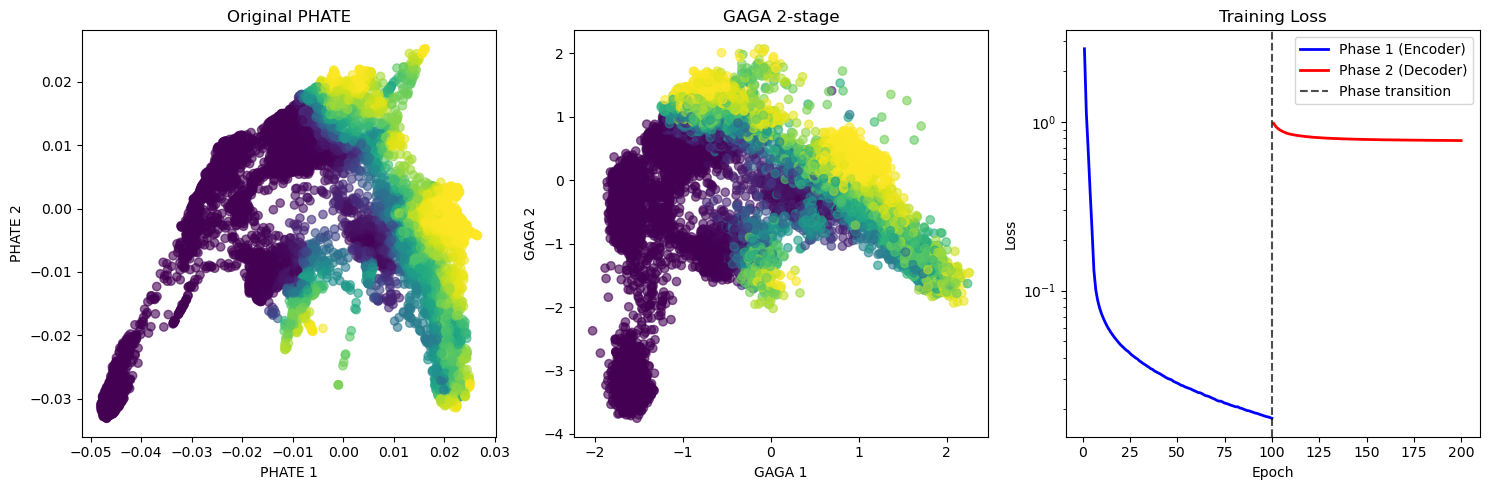

In [6]:

# Extract final losses for comparison (safely handle empty lists)
def get_final_losses(history_dict):
    final_losses = {}
    for k, v in history_dict.items():
        if k != 'learning_rates' and len(v) > 0:
            final_losses[k] = v[-1]
    return final_losses

phase1_final = get_final_losses(history['phase1'])
phase2_final = get_final_losses(history['phase2'])

print("Phase 1 final losses:", phase1_final)
print("Phase 2 final losses:", phase2_final)

print("Phase 1 final losses:", phase1_final)
print("Phase 2 final losses:", phase2_final)

# Generate embeddings
model.eval()
with torch.no_grad():
    pca_tensor = torch.from_numpy(X_pca)
    embeddings = model.encode(pca_tensor).numpy()

# Store for visualization
adata.obsm['X_gaga_2stage'] = embeddings

# Compare with original PHATE
print(f"Original PHATE shape: {adata.obsm['X_phate'].shape}")
print(f"GAGA embeddings shape: {embeddings.shape}")

# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original PHATE
axes[0].scatter(adata.obsm['X_phate'][:, 0], adata.obsm['X_phate'][:, 1], 
                c=adata.obs['pseudotime'], cmap='viridis', alpha=0.6)
axes[0].set_title('Original PHATE')
axes[0].set_xlabel('PHATE 1')
axes[0].set_ylabel('PHATE 2')

# GAGA 2-stage
axes[1].scatter(embeddings[:, 0], embeddings[:, 1], 
                c=adata.obs['pseudotime'], cmap='viridis', alpha=0.6)
axes[1].set_title('GAGA 2-stage')
axes[1].set_xlabel('GAGA 1')
axes[1].set_ylabel('GAGA 2')

# Training loss comparison
epochs_p1 = range(1, len(history['phase1']['train_loss']) + 1)
epochs_p2 = range(len(history['phase1']['train_loss']) + 1, 
                  len(history['phase1']['train_loss']) + len(history['phase2']['train_loss']) + 1)

axes[2].plot(epochs_p1, history['phase1']['train_loss'], 'b-', label='Phase 1 (Encoder)', linewidth=2)
axes[2].plot(epochs_p2, history['phase2']['train_loss'], 'r-', label='Phase 2 (Decoder)', linewidth=2)
axes[2].axvline(x=len(history['phase1']['train_loss']), color='k', linestyle='--', alpha=0.7, label='Phase transition')
axes[2].set_title('Training Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()


In [7]:
# Optional: Use MioFlow for trajectory analysis
print("\n=== Optional: MioFlow trajectory analysis ===")

# Ensure time_bin exists
print("Creating time_bin from time_label...")
adata.obs['time_bin'] = adata.obs['time_label'].map({
    'Day 00-03': 0.,
    'Day 06-09': 1.,
    'Day 12-15': 2.,
    'Day 18-21': 3.,
    'Day 24-27': 4.,
})

# Create time series data from the learned embeddings
time_bins = np.unique(adata.obs['time_bin'])
time_series_data = []
for t in time_bins:
    mask = adata.obs['time_bin'] == t
    points = embeddings[mask]
    time_series_data.append((points, float(t)))

mioflow_dataset = TimeSeriesDataset(time_series_data)
mioflow_model = ODEFunc(input_dim=2, hidden_dim=32)

# Train MioFlow
mioflow_history = train_mioflow(
    model=mioflow_model,
    dataset=mioflow_dataset,
    num_epochs=50,
    mode='local',
    batch_size=512,
    learning_rate=1e-3,
    lambda_ot=1.0,
    lambda_density=0.1,
    lambda_energy=0.01,
    energy_time_steps=10
)

print("MioFlow training completed!")


=== Optional: MioFlow trajectory analysis ===
Creating time_bin from time_label...


Epochs: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s, Total=0.3323, OT=0.3148, Density=0.0862, Energy=0.8814]

MioFlow training completed!


MioFlow final losses: {'epoch': 50.0, 'total_loss': 0.3322657309472561, 'ot_loss': 0.3148290328681469, 'density_loss': 0.08622519113123417, 'energy_loss': 0.8814182281494141}


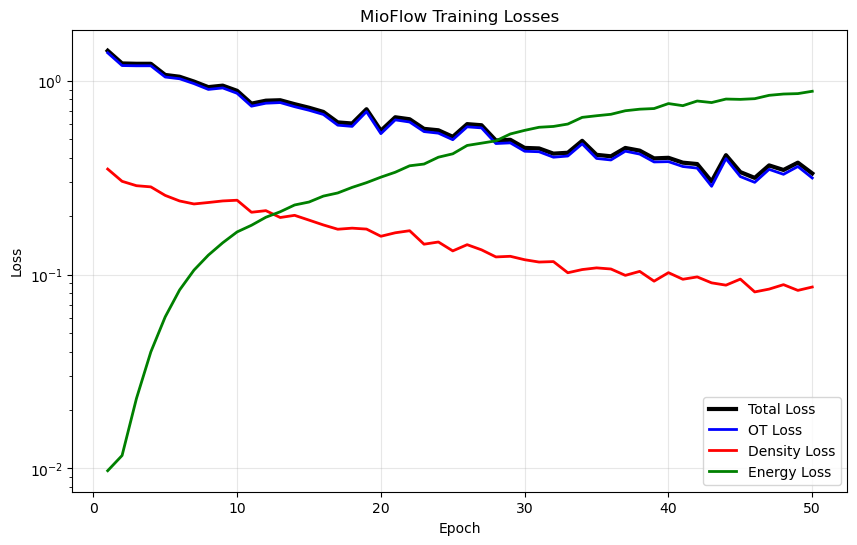

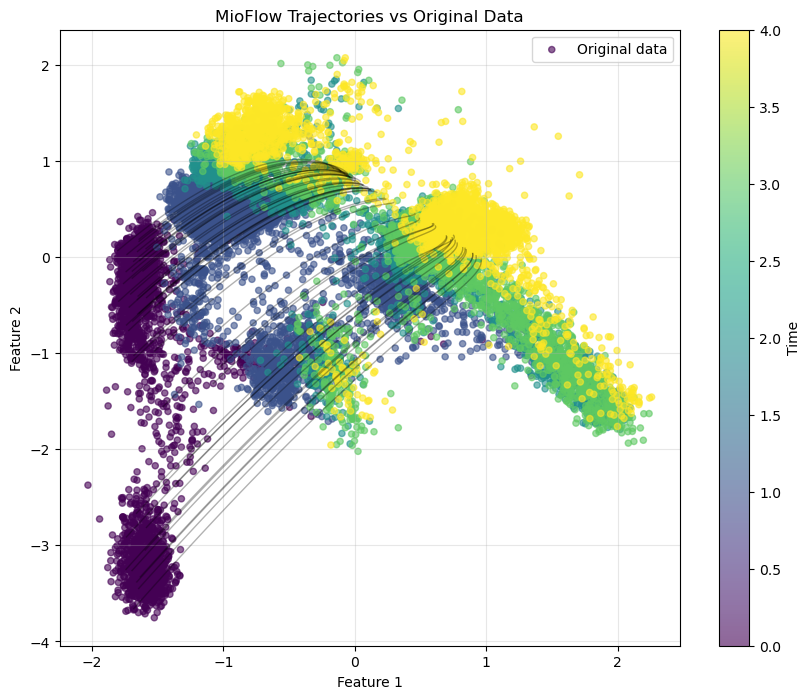

In [8]:
# Robust history processing (handle empty lists)
def get_final_losses(history_dict):
    """Safely extract final losses, handling empty lists and different data types."""
    final_losses = {}
    for k, v in history_dict.items():
        if k != 'learning_rates':
            try:
                # Handle different sequence types (list, numpy array, etc.)
                if hasattr(v, '__len__') and len(v) > 0:
                    final_losses[k] = float(v[-1])  # Convert to float for consistency
            except (IndexError, TypeError, KeyError):
                # Skip if we can't access the last element
                continue
    return final_losses


# Extract and print final losses
final_losses = get_final_losses(mioflow_history)
print("MioFlow final losses:", final_losses)

epochs = mioflow_history['epoch']

plt.figure(figsize=(10, 6))
plt.plot(epochs, mioflow_history['total_loss'], 'k-', linewidth=3, label='Total Loss')
plt.plot(epochs, mioflow_history['ot_loss'], 'b-', linewidth=2, label='OT Loss')
plt.plot(epochs, mioflow_history['density_loss'], 'r-', linewidth=2, label='Density Loss')
plt.plot(epochs, mioflow_history['energy_loss'], 'g-', linewidth=2, label='Energy Loss')

plt.title('MioFlow Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Optional: log scale for better visualization
plt.show()


# In[118]:


# Get initial condition and subsample points
X_0_full = mioflow_dataset.get_initial_condition()  # [full_size, n_features]
n_pts = 500  # or whatever subsample size you want
indices = torch.randperm(X_0_full.size(0))[:n_pts]
X_0_sample = X_0_full[indices]  # [n_pts, n_features]

# Get time range and create 100 time bins
times = mioflow_dataset.times
t_min, t_max = min(times), max(times)
t_bins = torch.linspace(t_min, t_max, 100)  # [100]

# Integrate trajectories
with torch.no_grad():
    trajectories = odeint(mioflow_model, X_0_sample, t_bins)  # [100, n_pts, n_features]

# Rearrange to [n_pts, 100, n_features] as requested
trajectories = trajectories.permute(1, 0, 2)  # [n_pts, 100, n_features]


# In[119]:


import matplotlib.pyplot as plt
import numpy as np

# Assuming 2D data - if higher dimensional, you might want to project first
# Get all original data points and their times
all_points = []
all_times = []
for i in range(len(mioflow_dataset.time_series_data)):
    points, time = mioflow_dataset.time_series_data[i]
    all_points.append(points)
    all_times.extend([time] * len(points))

all_points = np.vstack(all_points)  # [total_points, n_features]
all_times = np.array(all_times)     # [total_points]

# Create the plot
plt.figure(figsize=(10, 8))

# Plot original data points colored by time
scatter = plt.scatter(all_points[:, 0], all_points[:, 1], 
                     c=all_times, cmap='viridis', alpha=0.6, s=20,
                     label='Original data')

# Plot trajectories as lines
for i in range(min(50, trajectories.size(0))):  # Plot first 50 trajectories to avoid clutter
    traj = trajectories[i].cpu().numpy()  # [100, n_features]
    plt.plot(traj[:, 0], traj[:, 1], 'k-', alpha=0.3, linewidth=1)

# Add colorbar
plt.colorbar(scatter, label='Time')

plt.title('MioFlow Trajectories vs Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



In [15]:
batch = next(iter(dataloader))
model.eval()
with torch.no_grad():
    xh = model(batch['x'])

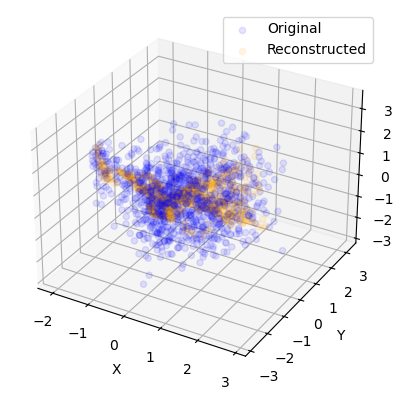

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(batch['x'][:, 0], batch['x'][:, 1], batch['x'][:, 2], c='blue', label='Original', alpha=0.1)
ax.scatter(xh[:, 0], xh[:, 1], xh[:, 2], c='orange', label='Reconstructed', alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()
